In [2]:
from dotenv import load_dotenv

load_dotenv()


True

In [3]:
from typing import (
    Annotated,
    Sequence,
    TypedDict,
)
from langchain_core.messages import BaseMessage
from langgraph.graph.message import add_messages


class AgentState(TypedDict):
    """The state of the agent."""

    # add_messages is a reducer
    # See https://langchain-ai.github.io/langgraph/concepts/low_level/#reducers
    messages: Annotated[Sequence[BaseMessage], add_messages]


In [4]:
from langchain_openai import ChatOpenAI
from langchain_core.tools import tool
from langchain_openai import AzureChatOpenAI

model = AzureChatOpenAI(model="gpt-4o-mini")
# model = ChatOpenAI(model="gpt-4o-mini")


# @tool
# def get_weather(location: str):
#     """Call to get the weather from a specific location."""
#     # This is a placeholder for the actual implementation
#     # Don't let the LLM know this though 😊
#     if any([city in location.lower() for city in ["sf", "san francisco"]]):
#         return "It's sunny in San Francisco, but you better look out if you're a Gemini 😈."
#     else:
#         return f"I am not sure what the weather is in {location}"


# tools = [get_weather]

# model = model.bind_tools(tools)

from langchain_core.tools import tool
from web_search import process_search_results, async_get_page_content


@tool
async def search(query):
    """
    tool for google search internet
    Args:
        query: str
    Output:
        List[str, any]
    """
    content_list = []
    urls = await process_search_results(input=query)
    # return urls
    for url in urls:
        content = await async_get_page_content(url)
        content_list.append(content)
    return content_list


tools = [search]

model = model.bind_tools(tools)


In [5]:
import json
from langchain_core.messages import ToolMessage, SystemMessage
from langchain_core.runnables import RunnableConfig

tools_by_name = {tool.name: tool for tool in tools}


# Define our tool node
async def tool_node(state: AgentState):
    outputs = []
    for tool_call in state["messages"][-1].tool_calls:
        tool_result = await tools_by_name[tool_call["name"]].ainvoke(tool_call["args"])
        outputs.append(
            ToolMessage(
                content=json.dumps(tool_result),
                name=tool_call["name"],
                tool_call_id=tool_call["id"],
            )
        )
    return {"messages": outputs}


# Define the node that calls the model
async def call_model(
    state: AgentState,
    config: RunnableConfig,
):
    # this is similar to customizing the create_react_agent with state_modifier, but is a lot more flexible
    system_prompt = SystemMessage(
        "You are a helpful AI assistant, please respond to the users query to the best of your ability!"
    )
    response = await model.ainvoke([system_prompt] + state["messages"], config)
    # We return a list, because this will get added to the existing list
    return {"messages": [response]}


# Define the conditional edge that determines whether to continue or not
def should_continue(state: AgentState):
    messages = state["messages"]
    last_message = messages[-1]
    # If there is no function call, then we finish
    if not last_message.tool_calls:
        return "end"
    # Otherwise if there is, we continue
    else:
        return "continue"


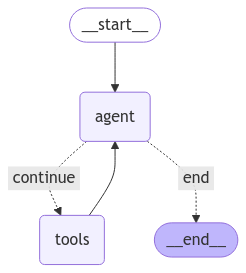

In [6]:
from langgraph.graph import StateGraph, END

# Define a new graph
workflow = StateGraph(AgentState)

# Define the two nodes we will cycle between
workflow.add_node("agent", call_model)
workflow.add_node("tools", tool_node)

# Set the entrypoint as `agent`
# This means that this node is the first one called
workflow.set_entry_point("agent")

# We now add a conditional edge
workflow.add_conditional_edges(
    # First, we define the start node. We use `agent`.
    # This means these are the edges taken after the `agent` node is called.
    "agent",
    # Next, we pass in the function that will determine which node is called next.
    should_continue,
    # Finally we pass in a mapping.
    # The keys are strings, and the values are other nodes.
    # END is a special node marking that the graph should finish.
    # What will happen is we will call `should_continue`, and then the output of that
    # will be matched against the keys in this mapping.
    # Based on which one it matches, that node will then be called.
    {
        # If `tools`, then we call the tool node.
        "continue": "tools",
        # Otherwise we finish.
        "end": END,
    },
)

# We now add a normal edge from `tools` to `agent`.
# This means that after `tools` is called, `agent` node is called next.
workflow.add_edge("tools", "agent")

# Now we can compile and visualize our graph
graph = workflow.compile()

from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass


In [45]:
from langchain_core.messages import BaseMessage, SystemMessage, HumanMessage
from langchain_core.messages.ai import AIMessageChunk

inputs = {
    "messages": [
        (
            "user",
            "ai là tổng bí thư?",
        )
    ]
}
async for msg, metadata in graph.astream(
    inputs, stream_mode="messages"
):  # Use async for to iterate over the stream
    if (
        msg and type(msg) is AIMessageChunk
        #   and isinstance(msg, HumanMessage) and not isinstance(msg, ToolMessage)
        # and metadata["langgraph_node"] == "final"
    ):
        # print(type(msg))
        print(msg.content, end="", flush=True)  # Call print_stream for each item
    else:
        print("tool name:", msg.name)
        print("tool content:", msg.content)

2024-12-06 13:25:34.745 | INFO     | web_search:process_search_results:22 - Before generate
2024-12-06 13:25:34.746 | INFO     | web_search:process_search_results:23 - Use Web
2024-12-06 13:25:34.746 | INFO     | web_search:process_search_results:25 - English question: ['tổng bí thư hiện nay là ai']
2024-12-06 13:25:34.747 | INFO     | web_search:process_search_results:27 - After generate
2024-12-06 13:25:34.748 | INFO     | web_search:process_search_results:31 - Before get_search_results


Queries: ['tổng bí thư hiện nay là ai']


2024-12-06 13:25:36.565 | INFO     | web_search:fetch_and_parse:150 - Fetch url: https://en.wikipedia.org/wiki/Nguy%E1%BB%85n_Ph%C3%BA_Tr%E1%BB%8Dng
2024-12-06 13:25:36.866 | INFO     | web_search:fetch_and_parse:150 - Fetch url: https://vi.wikipedia.org/wiki/Tổng_Bí_thư_Ban_Chấp_hành_Trung_ương_Đảng_Cộng_sản_Việt_Nam
2024-12-06 13:25:37.078 | INFO     | web_search:fetch_and_parse:150 - Fetch url: https://www.bbc.com/vietnamese/vietnam-52620147


tool name: search
tool content: ["Nguy\u1ec5n Ph\u00fa Tr\u1ecdng - Wikipedia\nJump to content\nMain menu\nMain menu\nmove to sidebar\nhide\nNavigation\nMain page\nContents\nCurrent events\nRandom article\nAbout Wikipedia\nContact us\nContribute\nHelp\nLearn to edit\nCommunity portal\nRecent changes\nUpload file\nSearch\nSearch\nAppearance\nDonate\nCreate account\nLog in\nPersonal tools\nDonate\nCreate account\nLog in\nPages for logged out editors\nlearn more\nContributions\nTalk\nContents\nmove to sidebar\nhide\n(Top)\n1\nEarly life and career\n2\nGeneral Secretaryship\nToggle General Secretaryship subsection\n2.1\nFirst term (2011\u20132016)\n2.1.1\nDomestic policy\n2.1.2\nForeign policy\n2.1.2.1\nChina\n2.1.2.2\nUnited States\n2.1.2.3\nIndia\n2.1.2.4\nRussia\n2.2\nSecond term (2016\u20132021)\n2.2.1\nAnti-corruption campaign\n2.2.2\nPresidency (2018\u20132021)\n2.3\nThird term (2021\u20132024)\n3\nPolitical positions\n4\nPersonal life\n5\nDeath\n6\nLegacy\n7\nHonours\nToggle Honours

In [33]:
msg


AIMessageChunk(content='', additional_kwargs={}, response_metadata={'finish_reason': 'stop', 'model_name': 'gpt-4o-mini', 'system_fingerprint': 'fp_04751d0b65'}, id='run-21936e56-4201-48cc-8143-6cca1b4a46b2')